In [1]:
# %% import package to use
import datatable
import pandas as pd
import xgboost as xgb
from IPython.display import display
import numpy as np
from lifelines.utils import concordance_index
import os
pd.set_option('display.max_columns', None)

In [2]:
# %%
DATA_PATH = "/home/lkh256/Studio/VO2max_Prediction/Results"
df_orig = datatable.fread(os.path.join(DATA_PATH, 'MF_general_eq_for_surv.csv'), na_strings=['', 'NA']).to_pandas()
df_orig['lower_bound'] = df_orig['delta_time']
df_orig['upper_bound'] = np.where(df_orig['death'] == 1, df_orig['lower_bound'], +np.inf)
df_orig.head()

# %%
feature_names = ['AGE', 'sex', 'Smoke', 'ALC', 'CRP', 'TG', 'Diabetes', 'HDL_C', 'LDL_C', 'MBP', 'ABRP_CRF']

"""
Option 1: Adjust age
Option 2: Adjust sex
Option 3: Adjust age and sex
Option 3: Non-adjust age and sex
"""
### Train Test split
# %%
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(df_orig, train_size=0.8, stratify=df_orig['death'], random_state=1005)

In [3]:
X_train = train_set[feature_names].values
dtrain = xgb.DMatrix(X_train)
dtrain.set_float_info('label_lower_bound', train_set['lower_bound'].values)
dtrain.set_float_info('label_upper_bound', train_set['upper_bound'].values)

X_test = test_set[feature_names].values
dtest = xgb.DMatrix(X_test)
dtest.set_float_info('label_lower_bound', test_set['lower_bound'].values)
dtest.set_float_info('label_upper_bound', test_set['upper_bound'].values)

from sklearn.model_selection import train_test_split

X_data = df_orig[feature_names]
y_data = np.zeros(df_orig.shape[0], dtype={'names':('death', 'delta_time'), 
                                           'formats':(bool, float)})
y_data['death'] = df_orig['death'].astype(bool)
y_data['delta_time'] = df_orig['delta_time'].astype(float)

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, train_size=0.8, stratify=y_data['death'], random_state=1005)

In [4]:
import pickle
with open('../Model/MF_survival_xg_results.pickle', 'rb') as file_nm:
    results = pickle.load(file_nm)
    
df_results = pd.DataFrame()
for condition in results:
    df_results = pd.concat((df_results, pd.DataFrame(results[condition])), axis=0)
best_param_mertic_xg = df_results[df_results['mean_score'] == df_results['mean_score'].max()][['max_depth', 'learning_rate', 'lambda', 'gamma', 'scores']].reset_index(drop=True)
best_param_mertic_xg.head()

,max_depth,learning_rate,lambda,gamma,scores
0,4,0.01,2,0.1,0.796010
1,4,0.01,2,0.1,0.651358
2,4,0.01,2,0.1,0.413001
3,4,0.01,2,0.1,0.643452
4,4,0.01,2,0.1,0.326064


In [5]:
params = {'objective': 'survival:aft', 
        'eval_metric': 'aft-nloglik', 
        'aft_loss_distribution': 'normal', 
        'aft_loss_distribution_scale': 1.20,
        'tree_method': 'gpu_hist', 
        'gpu_id': '0',
        'learning_rate': best_param_mertic_xg['learning_rate'].values[0], 
        'max_depth': best_param_mertic_xg['max_depth'].values[0],
        'lambda': best_param_mertic_xg['lambda'].values[0],
        'gamma': best_param_mertic_xg['gamma'].values[0]}

model_xgb = xgb.train(params, dtrain, num_boost_round=20000, evals=[(dtest, 'test')], verbose_eval=0, early_stopping_rounds=1000)

c_index = concordance_index(test_set['lower_bound'].values, 
                            model_xgb.predict(dtest), 
                            event_observed=test_set['death'].astype(int))
print(c_index)

0.5967623252391464


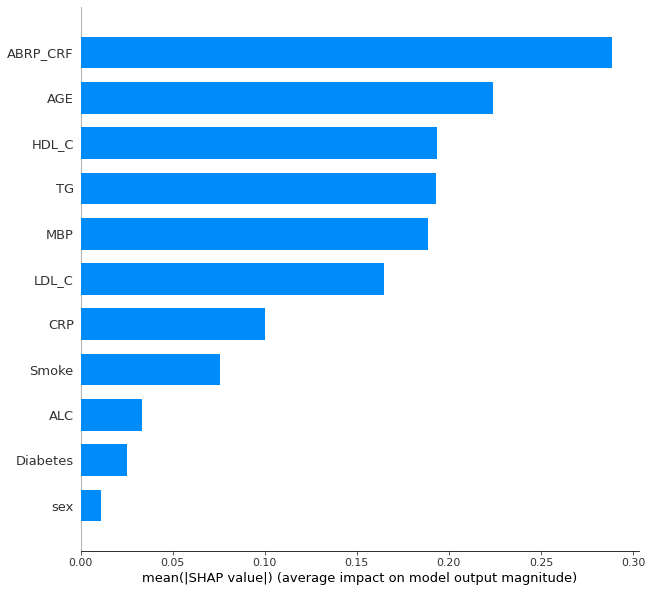

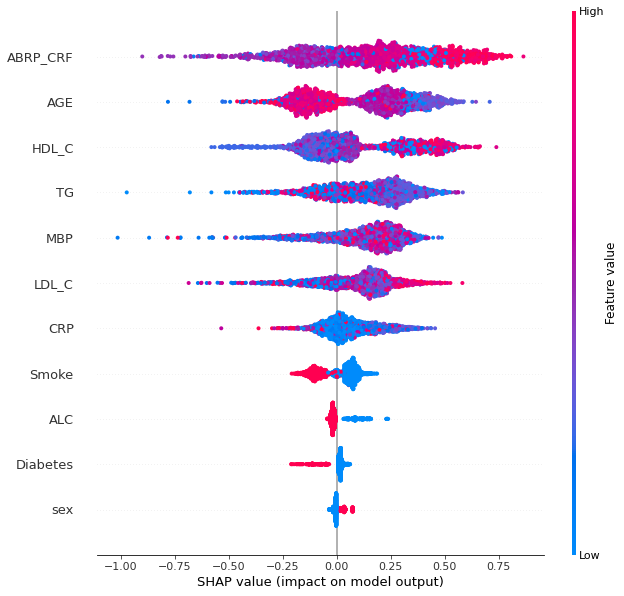

In [6]:
import shap
import matplotlib.pyplot as plt

explainer = shap.TreeExplainer(model_xgb)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar", feature_names=feature_names, plot_size=(10, 10))

shap.summary_plot(shap_values, X_test, feature_names=feature_names, plot_size=(10, 10))

In [8]:
import pickle
with open('../Model/MF_10_survival_rf_results.pickle', 'rb') as file_nm:
    results = pickle.load(file_nm)
    
df_results = pd.DataFrame()
for condition in results:
    df_results = pd.concat((df_results, pd.DataFrame(results[condition])), axis=0)
best_param_metric_rf = df_results[df_results['mean_score'] == df_results['mean_score'].max()][['max_features', 'num_trees', 'scores']].reset_index(drop=True)
best_param_metric_rf.head()

,max_features,num_trees,scores
0,sqrt,10,0.437645
1,sqrt,10,0.590324
2,sqrt,10,0.655566
3,sqrt,10,0.446144
4,sqrt,10,0.821362


In [9]:
from sksurv.ensemble import RandomSurvivalForest

model_rf = RandomSurvivalForest(n_estimators=best_param_metric_rf['num_trees'].values[0], max_features=best_param_metric_rf['max_features'].values[0], n_jobs=-1)

model_rf.fit(X=X_train, y=y_train)

c_index = model_rf.score(X_test, y_test)

print(c_index)

0.5285504047093451


Permutation explainer: 2173it [02:24, 14.16it/s]


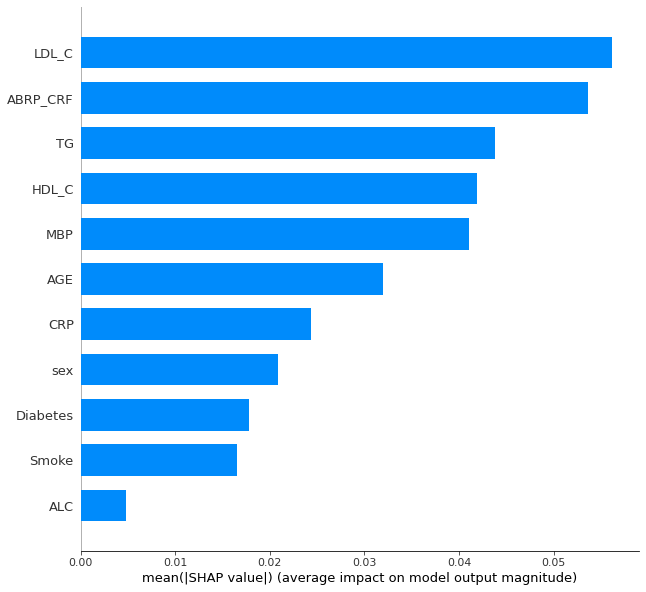

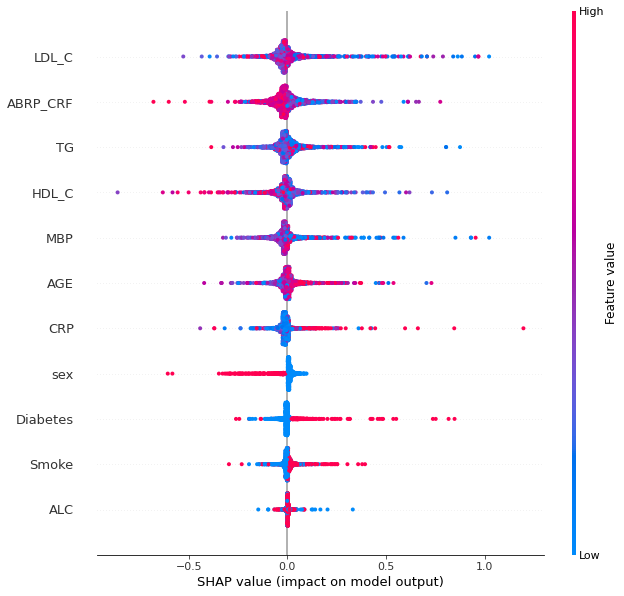

In [10]:
import shap
import matplotlib.pyplot as plt

explainer = shap.Explainer(model_rf.predict, X_train.astype(float))
shap_values = explainer(X_test.astype(float))

shap.summary_plot(shap_values, X_test, plot_type="bar", feature_names=feature_names, plot_size=(10, 10))

shap.summary_plot(shap_values, X_test, feature_names=feature_names, plot_size=(10, 10))

In [4]:
import pickle
with open('../Model/MF_10_survival_coxph_results.pickle', 'rb') as file_nm:
    results = pickle.load(file_nm)
    
df_results = pd.DataFrame()
for condition in results:
    df_results = pd.concat((df_results, pd.DataFrame(results[condition])), axis=0)
best_param_metric_cox = df_results[df_results['mean_score'] == df_results['mean_score'].max()][['ties', 'alpha', 'scores']].reset_index(drop=True)
display(best_param_metric_cox.head())
print(np.mean(best_param_metric_cox['scores']))

,ties,alpha,scores
0,efron,1.25,0.676224
1,efron,1.25,0.779290
2,efron,1.25,0.577001
3,efron,1.25,0.552883
4,efron,1.25,0.217517


0.6268001224563924


In [5]:
from sksurv.linear_model import CoxPHSurvivalAnalysis

model_coxph = CoxPHSurvivalAnalysis(ties=best_param_metric_cox['ties'].values[0], alpha=best_param_metric_cox['alpha'].values[0])

model_coxph.fit(X=X_train, y=y_train)

c_index = model_coxph.score(X_test, y_test)

print(c_index)


0.5564385577630611


Permutation explainer: 2173it [00:13, 48.13it/s]                           


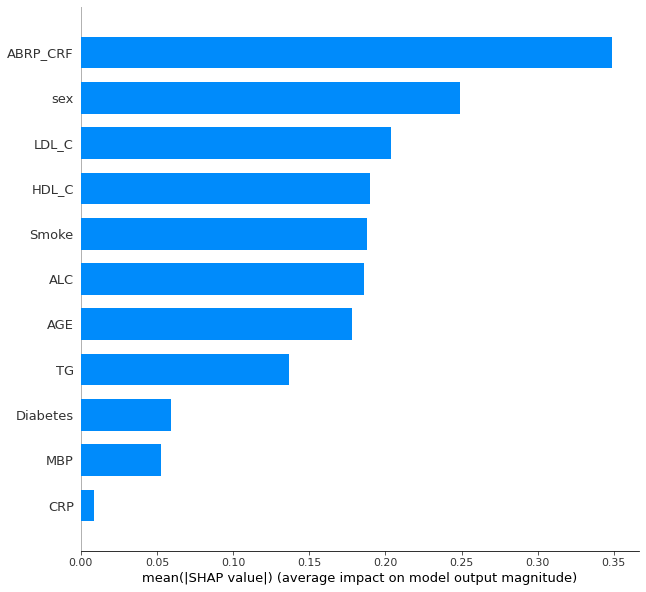

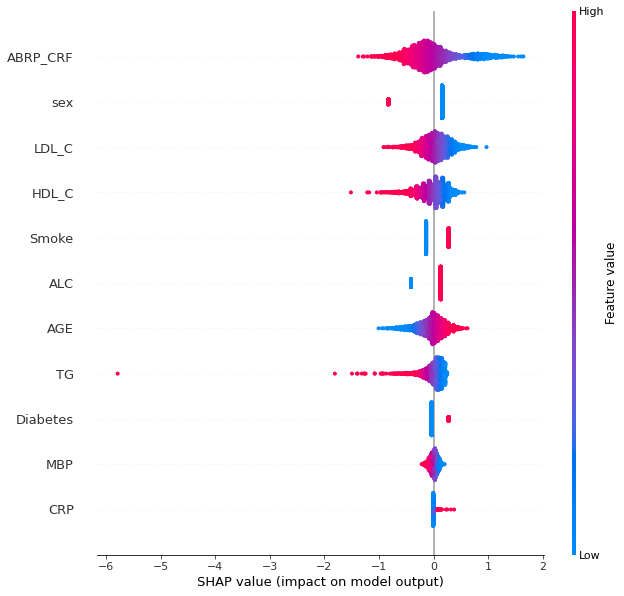

In [6]:
import shap
import matplotlib.pyplot as plt

explainer = shap.Explainer(model_coxph.predict, X_train.astype(float))
shap_values = explainer(X_test.astype(float))

shap.summary_plot(shap_values, X_test, plot_type="bar", feature_names=feature_names, plot_size=(10, 10))

shap.summary_plot(shap_values, X_test, feature_names=feature_names, plot_size=(10, 10))